In [1]:
import os

%pwd

'/home/tousside/Documents/recrutement/cowrywise-customer-plan-abandonment/research'

os.chdir("../")

%pwd



'/home/ubuntu/africlimateai/rainfall-prediction'

In [81]:
import pandas as pd

data = pd.read_csv("artifacts/data_transformation/train.csv", index_col="time")
data_test = pd.read_csv("artifacts/data_transformation/test.csv", index_col="time")

data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 2024-11-27 to 2025-06-21
Data columns (total 88 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temperature             207 non-null    float64
 1   feels_like              207 non-null    float64
 2   app_temp                207 non-null    float64
 3   dew_point               207 non-null    float64
 4   humidity                207 non-null    float64
 5   wind_direction          207 non-null    float64
 6   wind_speed              207 non-null    float64
 7   wind_gust               207 non-null    float64
 8   pressure_relative       207 non-null    float64
 9   pressure_absolute       207 non-null    float64
 10  rainfall                207 non-null    float64
 11  temperature(t-1)        207 non-null    float64
 12  temperature(t-2)        207 non-null    float64
 13  temperature(t-3)        207 non-null    float64
 14  temperature(t-4)        207 non

In [82]:
data.columns

Index(['temperature', 'feels_like', 'app_temp', 'dew_point', 'humidity',
       'wind_direction', 'wind_speed', 'wind_gust', 'pressure_relative',
       'pressure_absolute', 'rainfall', 'temperature(t-1)', 'temperature(t-2)',
       'temperature(t-3)', 'temperature(t-4)', 'temperature(t-5)',
       'temperature(t-6)', 'temperature(t-7)', 'feels_like(t-1)',
       'feels_like(t-2)', 'feels_like(t-3)', 'feels_like(t-4)',
       'feels_like(t-5)', 'feels_like(t-6)', 'feels_like(t-7)',
       'app_temp(t-1)', 'app_temp(t-2)', 'app_temp(t-3)', 'app_temp(t-4)',
       'app_temp(t-5)', 'app_temp(t-6)', 'app_temp(t-7)', 'dew_point(t-1)',
       'dew_point(t-2)', 'dew_point(t-3)', 'dew_point(t-4)', 'dew_point(t-5)',
       'dew_point(t-6)', 'dew_point(t-7)', 'humidity(t-1)', 'humidity(t-2)',
       'humidity(t-3)', 'humidity(t-4)', 'humidity(t-5)', 'humidity(t-6)',
       'humidity(t-7)', 'wind_direction(t-1)', 'wind_direction(t-2)',
       'wind_direction(t-3)', 'wind_direction(t-4)', 'wind_di

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch import optim
from torch.utils.data import DataLoader
from copy import deepcopy as dc

In [84]:
target="rainfall"
list(data.columns).index("rainfall")

10

In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [86]:
train_scaled = scaler.fit_transform(data)

In [87]:
features_columns_index = [i for i in range(len(data.columns)) if i!=10]
X_train = train_scaled[:, features_columns_index]
y_train = train_scaled[:, 10]

In [88]:
y_train.shape

(207,)

In [89]:
test_scaled = scaler.transform(data_test)

In [90]:
X_test = test_scaled[:, features_columns_index]
y_test = test_scaled[:, 10]

In [91]:
X_train= dc(np.flip(X_train, axis=1))
X_test= dc(np.flip(X_test, axis=1))


In [94]:
X_train.shape

(207, 87)

In [95]:
lookback= 87

In [96]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train =y_train.reshape((-1, 1))
y_test =y_test.reshape((-1, 1))


In [99]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [102]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    def     __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [103]:
batch_size = 8
train_loader =  DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader =  DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [104]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        bacth_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [114]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [107]:
def train_one_epoch(train_loader,
                    test_loader,
                    num_epochs, 
                    loss_function, 
                    optimizer,
                    validate_one_epoch_function):
    model.train(True)
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}")
        running_loss = 0.0
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output,_ ,_= model(x_batch)

            loss = loss_function(output, y_batch)
            running_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        if batch_index % 100 == 99:
            average_loss_across_batches = running_loss/100
            print("Batch {0}, Loss: {1:.3f}".format(batch_size+1, average_loss_across_batches))
            running_loss = 0.0
        validate_one_epoch_function(test_loader, loss_function)
        print()


In [108]:
def validate_one_epoch(test_loader, loss_function):
    model.train(False)
    running_loss = 0

    for _, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output,_,_ = model(x_batch)

            loss = loss_function(output, y_batch)
            running_loss+=loss

            average_loss_across_batches = running_loss/len(test_loader)
    print("Val Loss {0:.3f}".format(average_loss_across_batches))
    print("**************************************************")
    print()


In [ ]:
leraning_rate = 0.001
num_epochs = 
optimizer = optim.Adam(model.parameters(), lr = leraning_rate)
loss_function = nn.MSELoss()

train_one_epoch(train_loader,
                    test_loader,
                    num_epochs, 
                    loss_function, 
                    optimizer,
                    validate_one_epoch)



Epoch: 1
Val Loss 0.622
**************************************************


Epoch: 2


Val Loss 0.518
**************************************************


Epoch: 3
Val Loss 0.403
**************************************************


Epoch: 4
Val Loss 0.286
**************************************************


Epoch: 5
Val Loss 0.182
**************************************************


Epoch: 6
Val Loss 0.109
**************************************************


Epoch: 7
Val Loss 0.065
**************************************************


Epoch: 8
Val Loss 0.039
**************************************************


Epoch: 9
Val Loss 0.027
**************************************************


Epoch: 10
Val Loss 0.022
**************************************************




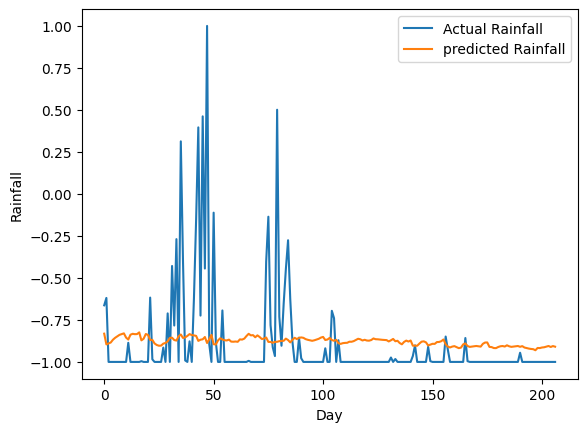

In [112]:
with torch.no_grad():
    predicted,_ , _= model(X_train.to(device))
    predicted = predicted.to("cpu").numpy()
plt.plot(y_train, label = "Actual Rainfall")
plt.plot(predicted, label = "predicted Rainfall")
plt.xlabel("Day")
plt.ylabel("Rainfall")
plt.legend()
plt.show()

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_name: str
    model_params: dict
    target_column: str

In [45]:


from mlProject.constants import *
from mlProject.utils.common import read_yaml, create_directories

In [ ]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])


    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer
        model_params = self.params.XGBoost
        schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_trainer_config = ModelTrainerConfig(
            root_dir=config.root_dir,
            train_data_path = config.train_data_path,
            test_data_path = config.test_data_path,
            model_name = config.model_name,
            model_params = model_params,
            target_column = schema.name
            
        )

        return model_trainer_config

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier  # or any other model
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
import joblib

In [ ]:

class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config
    def array_to_str_keyed_dict_list(self, X):
        """
        Converts a 2D array into a list of dictionaries
        where keys are string representations of column indices.
        """
        return [dict(zip(map(str, range(X.shape[1])), row)) for row in X]

    
    def train(self):
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)


        train_x = train_data.drop([self.config.target_column], axis=1)
        test_x = test_data.drop([self.config.target_column], axis=1)
        train_y = train_data[[self.config.target_column]]
        test_y = test_data[[self.config.target_column]]
        
        # gender_id , and type as categorical variables
        categorical_cols = ["gender_id", "type"]
        train_x[categorical_cols] = train_x[categorical_cols].astype(str)
        
        numeric_cols = train_x.select_dtypes(include=["int64", "float64"]).columns.tolist()
        
        # Step 3: ColumnTransformer for imputing
        preprocessor = ColumnTransformer(transformers=[
            ("num", SimpleImputer(strategy="median"), numeric_cols),
            ("scaler", StandardScaler(), numeric_cols),
            ("cat", SimpleImputer(strategy="most_frequent"), categorical_cols)
        ], remainder="passthrough")  # Keep other columns (if any)

        pipeline = Pipeline([
            ("preprocessing", preprocessor),
            ("to_dict", FunctionTransformer(self.array_to_str_keyed_dict_list)),
            ("vectorize", DictVectorizer()),
            ('classifier', XGBClassifier(**self.config.model_params, random_state=42))
        ])

        
        pipeline.fit(train_x, train_y)

        joblib.dump(pipeline, os.path.join(self.config.root_dir, self.config.model_name))

try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer_config = ModelTrainer(config=model_trainer_config)
    model_trainer_config.train()
except Exception as e:
    raise e

